# Retinal vessel segmentation
Retinal vessel segmentation is the task of segmenting blood vessels in retinal images. It is an essential task for developing the computer-aided diagnosis system for retinal diseases.

| ![](https://github.com/orobix/retina-unet/raw/master/test/test_Original_GroundTruth_Prediction3.png) |
|:--:|
| <b>Retinal vessel segmentation</b> |

# U-Net architecture
| ![](https://camo.githubusercontent.com/bc2e09476b5c7db5ea4e19251ac9a19af9ba5a89f16d58f72459059c3cffb969/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f3830302f312a6a716f416d4579516d784b704763416b6250474e4d512e706e67) |
|:--:|
| <b>U-Net model</b> |

The U-Net is convolutional network architecture for fast and precise segmentation of images. It is an encoder-decoder model with some skip connections between. The major advantage of this architecture is its ability to take into account a wider context when making a prediction for a pixel (foreground vs. background). This model consists of large number of channels used in the up-sampling operation.

In [1]:
# Python
import os
import numpy as np
import random
import configparser
from matplotlib import pyplot as plt
from PIL import Image
import cv2

# Keras
from keras.models import model_from_json
from keras.models import Model

In [2]:
# Data paths
training_1st_manual = './DRIVE/training/1st_manual/'
training_images = './DRIVE/training/images/'
training_masks = './DRIVE/training/mask/'
test_images = './DRIVE/test/images/'
test_masks = './DRIVE/test/mask/'

# Dimensions of patch
patch_height = 48
patch_width = 48

# Training settings
n_epochs = 150
batch_size = 32
n_patches = 100

## 1. Get dataset

The follwing helps to parse the images from the given files into a numpy array.

In [3]:
Nimgs = 20
channels = 3
height = 584
width = 565
dataset_path = "./DRIVE_datasets_training_testing/"

def get_datasets(imgs_dir,groundTruth_dir,borderMasks_dir,train_test="null"):
    imgs = np.empty((Nimgs,height,width,channels))
    groundTruth = np.empty((Nimgs,height,width))
    border_masks = np.empty((Nimgs,height,width))
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #original
            #print ("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            imgs[i] = np.asarray(img)
            #corresponding ground truth
            groundTruth_name = files[i][0:2] + "_manual1.gif"
            #print ("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            groundTruth[i] = np.asarray(g_truth)
            #corresponding border masks
            border_masks_name = ""
            if train_test=="train":
                border_masks_name = files[i][0:2] + "_training_mask.gif"
            elif train_test=="test":
                border_masks_name = files[i][0:2] + "_test_mask.gif"
            else:
                print ("specify if train or test!!")
                exit()
            #print ("border masks name: " + border_masks_name)
            b_mask = Image.open(borderMasks_dir + border_masks_name)
            border_masks[i] = np.asarray(b_mask)

    #print ("imgs max: " +str(np.max(imgs)))
    #print ("imgs min: " +str(np.min(imgs)))
    assert(np.max(groundTruth)==255 and np.max(border_masks)==255)
    assert(np.min(groundTruth)==0 and np.min(border_masks)==0)
    #print ("ground truth and border masks are correctly withih pixel value range 0-255 (black-white)")
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,channels,height,width))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,height,width))
    border_masks = np.reshape(border_masks,(Nimgs,1,height,width))
    assert(groundTruth.shape == (Nimgs,1,height,width))
    assert(border_masks.shape == (Nimgs,1,height,width))
    return imgs, groundTruth, border_masks

## 2. Pre-processing images
Before training, the 20 images of DRIVE training datasets are pre-processed with the following steps:
- Gray-scale conversion
- Normalization
- Contrast-limited adaptive historam equalization (CLAHE)
- Gamma adjustment

In [4]:
# Gray-scale conversion
def rgb2gray(rgb_imgs):
    assert len(rgb_imgs.shape) == 4 # 4D arrays
    assert rgb_imgs.shape[1] == 3 # Check the original RGB images
    
    bn_imgs = rgb_imgs[:,0,:,:]*0.299 + rgb_imgs[:,1,:,:]*0.587 + rgb_imgs[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb_imgs.shape[0], 1, rgb_imgs.shape[2], rgb_imgs.shape[3]))
    
    return bn_imgs

In [5]:
# Normalization
def dataset_normalize(imgs):
    assert len(imgs.shape) == 4 # 4D arrays
    assert imgs.shape[1] == 1 # Check the gray-scale images
    
    # Normalize mean and standard deviation of the images
    normalized_imgs = np.empty(imgs.shape)
    normalized_imgs = (imgs-np.mean(imgs))/np.std(imgs)
    
    for i in range(imgs.shape[0]):
        normalized_imgs[i] = ((normalized_imgs[i]-np.min(normalized_imgs[i]))/(np.max(normalized_imgs[i])-np.min(normalized_imgs[i])))*255
        
        return normalized_imgs

In [6]:
# Histogram equalization
def his_equalized(imgs):
    assert len(imgs.shape) == 4 # 4D arrays
    assert imgs.shape[1] == 1 # Check the gray-scale images
    
    equalized_imgs = np.empty(imgs.shape)
    
    for i in range(imgs.shape[0]):
        equalized_imgs[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype=np.uint8))
    
    return equalized_imgs

In [7]:
# Contrast-limited adaptive histogram equalization (CLAHE)
def clahe(imgs):
    assert len(imgs.shape) == 4 # 4D arrays
    assert imgs.shape[1] == 1 # Check the gray-scale images
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_imgs = np.empty(imgs.shape)
    
    for i in range(imgs.shape[0]):
        clahe_imgs[i,0] = clahe.apply(np.array(imgs[i,0], dtype=np.uint8))
    
    return clahe_imgs

In [8]:
# Gamma adjustment
def gamma_adjust(imgs, gamma):
    assert len(imgs.shape) == 4 # 4D arrays
    assert imgs.shape[1] == 1 # Check the gray-scale images
    
    # Build a lookup table mapping the pixel values to their adjusted gamma values
    inv_gamma = 1.0/gamma
    table = np.array([((i/255)**inv_gamma) for i in np.arange(0,256)]).astype('uint8')
    
    # Apply gamma adjustment using the lookup table
    adjusted_imgs = np.empty(imgs.shape)

    for i in range(imgs.shape[0]):
        adjusted_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype=np.uint8), table)
        
    return adjusted_imgs

In [9]:
# Pre-processing data
def pre_process(original_imgs):
    assert len(original_imgs.shape) == 4 # 4D arrays
    assert original_imgs.shape[1] == 3 # Check the original RGB images
    
    train_imgs = rgb2gray(original_imgs)
    train_imgs = dataset_normalize(train_imgs)
    #train_imgs = clahe(train_imgs)
    train_imgs = gamma_adjust(train_imgs, 1.2)
    train_imgs = train_imgs/255.
    
    return train_imgs

## 3. Extract image patches
The training of U-Net model is performed on sub-images (called patches of dimension 48x48) of the pre-processed images. Each patch has the randomly selected center in the full image. You can choose wether the patches should also contain some of the border regions or if they should be completely inside the FOV.

In [10]:
# Check if the patch is fully contained in the FOV
def is_patch_inside_FOV(x, y, img_width, img_height, patch_height):
    x_ = x-int(img_width/2) # Origin (0,0) is shifted to image center
    y_ = y-int(img_height/2)  # Origin (0,0) is shifted to image center
    
    # The limit to contain the full patch in the FOV
    R_inside = 270-int((patch_height*np.sqrt(2.0))/2) # Radius is 270 (from DRIVE docs), minus the patch diagonal (assumed it is a square)
    radius = np.sqrt((x_*x_)+(y_*y_))
    if radius < R_inside:
        return True
    else:
        return False

In [11]:
# Extract patches from original images
def extract_patches(original_imgs, masks, patch_height, patch_width, n_patches, inside=True):
    if n_patches%original_imgs.shape[0] != 0:
        exit()
    assert len(original_imgs.shape) == 4 and len(masks.shape) == 4 # 4D arrays
    assert original_imgs.shape[1] == 1 or original_imgs.shape[1] == 3
    assert masks.shape[1] == 1
    
    patches = np.empty((n_patches, original_imgs.shape[1], patch_height, patch_width))
    mask_patches = np.empty((n_patches, masks.shape[1], patch_height, patch_width))
    img_height = original_imgs.shape[2]
    img_width = original_imgs.shape[3]
    
    n_patches_per_img = int(n_patches/original_imgs.shape[0])
    print('Number of patches per full original image: ' + str(n_patches_per_img))
    
    iter_total = 0 # Total iterations of patch through the original images
    for i in range(original_imgs.shape[0]): # Loop over full original images
        k = 0
        while k < n_patches_per_img:
            x_center = random.randint(0+int(patch_width/2), img_width-int(patch_width/2))
            y_center = random.randint(0+int(patch_height/2), img_height-int(patch_height/2)) 
            if inside == True:
                if is_patch_inside_FOV(x_center, y_center, img_width, img_height, patch_height) == False:
                    continue
            patch = original_imgs[i, :, y_center-int(patch_height/2):y_center+int(patch_height/2), x_center-int(patch_width/2):x_center+int(patch_width/2)]
            mask_patch = masks[i, :, y_center-int(patch_height/2):y_center+int(patch_height/2), x_center-int(patch_width/2):x_center+int(patch_width/2)]
            patches[iter_total] = patch
            mask_patches[iter_total] = mask_patch
            iter_total += 1   # Go to next iteration
            k += 1     
    return patches, mask_patches

## 4. Prepare the data

We will use the funtions defined above, to get the dataset, preprocess ist and extract the patches. 

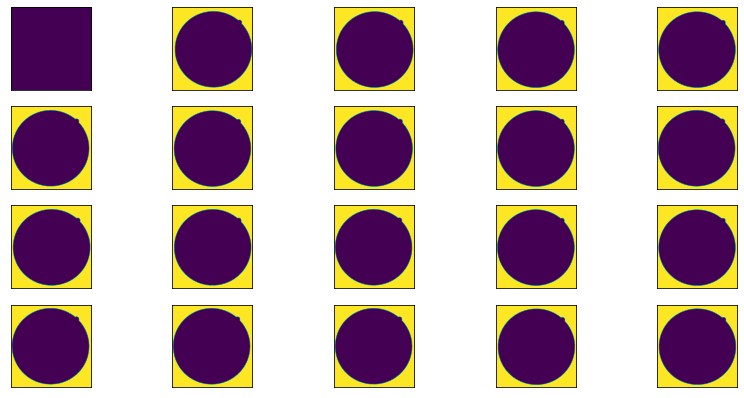

In [12]:
imgs_train, groundTruth_train, border_masks_train = get_datasets(training_images,training_1st_manual,training_masks,"train")
imgs_train = pre_process(imgs_train)
groundTruth_train =  groundTruth_train/255

plt.rcParams["figure.figsize"] = (14,7)
fig, axs = plt.subplots(4,5)
k=0
for x in range(0,4):
    for y in range(0,5):
        axs[x][y].imshow(imgs_train[k][0])
        axs[x][y].get_xaxis().set_visible(False)
        axs[x][y].get_yaxis().set_visible(False)
        k=k+1

Extract the patches.

Number of patches per full original image: 95


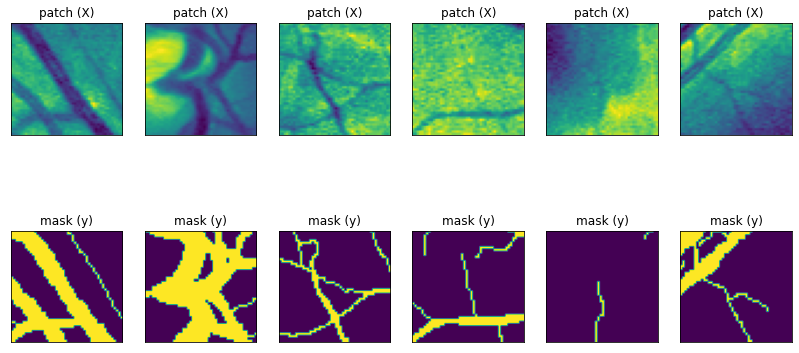

In [13]:
patches, mask_patches = extract_patches(imgs_train, groundTruth_train, patch_height, patch_width, n_patches)

fig, axs = plt.subplots(2,6)
k=0
for y in range(0,6):
    axs[0][y].imshow(patches[k][0])
    axs[0][y].get_xaxis().set_visible(False)
    axs[0][y].get_yaxis().set_visible(False)
    axs[0][y].set_title("patch (X)")
    
    axs[1][y].imshow(mask_patches[k][0])
    axs[1][y].get_xaxis().set_visible(False)
    axs[1][y].get_yaxis().set_visible(False)
    axs[1][y].set_title("mask (y)")
    k=k+10

Split the data into a training, testing and validation set.
We use the data from DRIVE/training for all of them, because the data in Drive/test is not labeled (i.e. no masks(y) avaiable).

In [14]:
X_train, X_test, X_val = patches[:int(0.8*n_patches)], patches[int(0.8*n_patches):int(0.9*n_patches)], patches[int(0.9*n_patches):]
y_train, y_test, y_val = mask_patches[:int(0.8*n_patches)], mask_patches[int(0.8*n_patches):int(0.9*n_patches)], mask_patches[int(0.9*n_patches):]

del patches
del mask_patches

## 5. Define the model

U-Net will now be build using Keras.

In [15]:
from tensorflow import keras

def get_unet(n_ch,patch_height,patch_width):
    inputs = keras.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = keras.layers.Dropout(0.2)(conv1)
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = keras.layers.Dropout(0.2)(conv2)
    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = keras.layers.Dropout(0.2)(conv3)
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = keras.layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = keras.layers.concatenate([conv2,up1],axis=1)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = keras.layers.Dropout(0.2)(conv4)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = keras.layers.concatenate([conv1,up2], axis=1)
    conv5 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = keras.layers.Dropout(0.2)(conv5)
    conv5 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = keras.layers.Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = keras.layers.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = keras.layers.Permute((2,1))(conv6)
    ############
    conv7 = keras.layers.Activation('softmax')(conv6)

    model = keras.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Help function, to match the labels to the models output.

In [16]:
def masks_Unet(masks):
    assert (len(masks.shape)==4)  #4D arrays
    assert (masks.shape[1]==1 )  #check the channel is 1
    im_h = masks.shape[2]
    im_w = masks.shape[3]
    masks = np.reshape(masks,(masks.shape[0],im_h*im_w))
    new_masks = np.empty((masks.shape[0],im_h*im_w,2))
    for i in range(masks.shape[0]):
        for j in range(im_h*im_w):
            if  masks[i,j] == 0:
                new_masks[i,j,0]=1
                new_masks[i,j,1]=0
            else:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=1
    return new_masks

## 6. Train the model

In [17]:
model = get_unet(1,patch_height,patch_width)

y_train = masks_Unet(y_train)
y_test = masks_Unet(y_test)

model.summary()

2022-03-10 13:49:29.287724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 48, 48)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 48, 48)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 48, 48)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 48, 48)   9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=2, validation_data=(X_val, y_val))